Universidad del valle de Guatemala

Dpto. Ciencias de la computacion

Aprendizaje por Refuerzo

Alberto Suriano  


Proyecto Final de curso  
Marlon Hernández - 15177  

[Repositorio_aqui](https://github.com/ivanhez/RL-Proyecto.git)  

[Video_aqui]()

In [17]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations as comb

In [18]:
'''
Definir la jerarquía de números y palos
'''
rank_names = ['3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A', '2']
suit_names = ['♦', '♣', '♥', '♠']


'''
Definir en entorno del juego
'''
class ChoDaiDiEnv(gym.Env):
    def __init__(self, num_players=4):
        super(ChoDaiDiEnv, self).__init__()
        self.num_players = num_players
        
        # Definir espacios de acción y observación
        self.action_space = None
        self.observation_space = spaces.Box(low=0, high=1, shape=(num_players, 52), dtype=np.int32)
        self.reset()
        
        
    # Estado inicial del juego y mesa vacía
    def reset(self):
        self.state = self._deal_cards()
        self.done = False
        self.current_combination = None  # No hay combinación en la mesa inicialmente
        self.passes_in_row = 0    # Contador de pases consecutivos
        self.played_cards = []    # Lista de combinaciones jugadas en el último paso


        # Encontrar al jugador que tiene la carta 3♣ e iniciar el juego
        three_of_clubs = 1 * 13 + 0
        self.current_player = None
        for i in range(self.num_players):
            if self.state[i][three_of_clubs] == 1:
                self.current_player = i
                break
        if self.current_player is None:
            self.current_player = 0
        return self.state

    # Dar un paso
    def step(self, action):
        rewards = [0 for _ in range(self.num_players)]
        info = {}
        self.played_cards = []  # Reiniciar la lista de combinaciones jugadas
        i = self.current_player  # Jugador actual
        valid_move = False

        if action == 'pass':  # El jugador decide pasar
            if self.current_combination is None:
                # No se puede pasar si la mesa está vacía
                rewards[i] -= 50
                self.played_cards.append((i, 'Inválido'))
                valid_move = False
            else:
                self.passes_in_row += 1
                self.played_cards.append((i, 'pass'))  # El jugador pasó
                rewards[i] -= 25
                valid_move = True
                # Verificar si todos los demás jugadores han pasado
                if self.passes_in_row >= self.num_players - 1:
                    # Reiniciar la ronda
                    self.current_combination = None
                    self.passes_in_row = 0
        else:
            if self.is_valid_combination(action, i):
                if self.current_combination is None or self.is_higher_combination(action, self.current_combination):
                    for card_id in action:
                        self.state[i][card_id] -= 1
                    rewards[i] += 50
                    self.current_combination = action
                    self.passes_in_row = 0  # Reiniciar los pases consecutivos
                    self.played_cards.append((i, action))
                    valid_move = True
                else:
                    rewards[i] -= 100
                    self.played_cards.append((i, 'Inválido'))
                    valid_move = False
            else:
                rewards[i] -= 100
                self.played_cards.append((i, 'Inválido'))
                valid_move = False

        # Verificar si el jugador actual se ha quedado sin cartas
        if np.sum(self.state[i]) == 0 and not self.done:
            self.done = True
            rewards[i] += 500
            info['winner'] = i

        if valid_move:
            self.current_player = (self.current_player + 1) % self.num_players
        else:
            pass

        info['valid_move'] = valid_move
        next_state = self.state.copy()
        return next_state, rewards, self.done, info


    # Validar si es una combinación
    def is_valid_combination(self, combination, player_index):
        if not isinstance(combination, list) or len(combination) == 0:
            return False
        for card_id in combination:
            if self.state[player_index][card_id] == 0:
                return False
        ranks = [card_id % 13 for card_id in combination]
        suits = [card_id // 13 for card_id in combination]
        if len(set(ranks)) == 1:
            return True
        elif len(combination) == 5:
            ranks_sorted = sorted(ranks)
            suits_set = set(suits)
            is_sequence = ranks_sorted == list(range(ranks_sorted[0], ranks_sorted[0] + 5))
            is_flush = len(suits_set) == 1
            rank_counts = {rank: ranks.count(rank) for rank in set(ranks)}
            is_full_house = sorted(rank_counts.values()) == [2, 3]
            if is_sequence and is_flush:
                return True
            elif is_full_house:
                return True
            elif is_flush:
                return True
            elif is_sequence:
                return True
            else:
                return False
        else:
            return False


    # Obtener el ranking de combinación
    def get_combination_score(self, combination):
        ranks = [card_id % 13 for card_id in combination]
        suits = [card_id // 13 for card_id in combination]
        ranks_sorted = sorted(ranks)
        suits_set = set(suits)
        is_sequence = ranks_sorted == list(range(ranks_sorted[0], ranks_sorted[0] + 5))
        is_flush = len(suits_set) == 1
        rank_counts = {rank: ranks.count(rank) for rank in set(ranks)}
        is_full_house = sorted(rank_counts.values()) == [2, 3]
        if len(combination) == 5:
            if is_sequence and is_flush:
                return (4, ranks_sorted[-1])
            elif is_full_house:
                return (3, max(rank_counts, key=lambda x: (rank_counts[x], x)))  # Nivel 3
            elif is_flush:
                return (2, ranks_sorted[-1])
            elif is_sequence:
                return (1, ranks_sorted[-1])
            else:
                return (0, ranks_sorted[-1])
        else:
            return (0, ranks_sorted[0])


    # Determinar si la combinación es mayor
    def is_higher_combination(self, new_combination, current_combination):
        if len(new_combination) != len(current_combination):
            return False
        new_score, new_rank = self.get_combination_score(new_combination)
        current_score, current_rank = self.get_combination_score(current_combination)
        if new_score > current_score:
            return True
        elif new_score == current_score:
            if new_rank > current_rank:
                return True
            else:
                return False
        else:
            return False


    # Renderizar el juego
    def render(self, agent_names=None):
        for i in range(self.num_players):
            hand = []
            for card_id in np.where(self.state[i] > 0)[0]:
                rank = card_id % 13
                suit = card_id // 13
                rank_name = rank_names[rank]
                suit_name = suit_names[suit]
                hand.append(f"{rank_name}{suit_name}")
            player_name = agent_names[i] if agent_names else f"Jugador {i+1}"
            print(f"{player_name}: Cartas restantes: {len(hand)} - Mano: {hand}")

        # Mostrar la acción del jugador actual
        if self.played_cards:
            player_index, card_info = self.played_cards[0]
            player_name = agent_names[player_index] if agent_names else f"Jugador {player_index+1}"
            if card_info == 'pass':
                print(f"\n{player_name} pasó.")
            elif card_info == 'Inválido':
                print(f"\n{player_name} realizó un movimiento inválido.")
            else:
                # Mostrar la combinación jugada
                combination = []
                for card_id in card_info:
                    rank = card_id % 13
                    suit = card_id // 13
                    rank_name = rank_names[rank]
                    suit_name = suit_names[suit]
                    combination.append(f"{rank_name}{suit_name}")
                print(f"\n{player_name} juega: {combination}")

        if self.current_combination is not None:
            combination = []
            for card_id in self.current_combination:
                rank = card_id % 13
                suit = card_id // 13
                rank_name = rank_names[rank]
                suit_name = suit_names[suit]
                combination.append(f"{rank_name}{suit_name}")
            print(f"\nCombinación actual en la mesa: {combination}")
        else:
            print("\nNo hay combinación en la mesa.")

        # Mostrar quién es el siguiente en jugar
        next_player_index = self.current_player
        next_player_name = agent_names[next_player_index] if agent_names else f"Jugador {next_player_index+1}"
        print(f"\nTurno siguiente: {next_player_name}\n")

    
    # Repartir las cartas aleatoriamente
    def _deal_cards(self):
        deck = np.arange(52)
        np.random.shuffle(deck)
        hands = np.array_split(deck, self.num_players)
        state = np.zeros((self.num_players, 52), dtype=np.int32)
        for i in range(self.num_players):
            for card_id in hands[i]:
                state[i][card_id] = 1
        return state

In [19]:
'''
Implementación del Q-Learning Agent
''' 
class QLearningAgent:
    def __init__(self, state_space, action_space, env):
        self.alpha = 0.1
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.01
        self.q_table = {}

    def get_state_key(self, current_combination):
        if current_combination is None:
            return ('empty',)
        else:
            size = len(current_combination)
            rank = current_combination[0] % 13
            return (size, rank)

    def get_possible_actions(self, hand, current_combination):
        possible_combinations = self.get_possible_combinations(hand)
        valid_actions = []
        for combo in possible_combinations:
            if self.is_valid_move(combo, current_combination):
                valid_actions.append(tuple(sorted(combo)))
        if not valid_actions:
            valid_actions.append('pass')
        return valid_actions

    def choose_action(self, state, player_index, current_combination):
        state_key = self.get_state_key(current_combination)
        hand = state[player_index]
        possible_actions = self.get_possible_actions(hand, current_combination)
        if np.random.rand() < self.epsilon or state_key not in self.q_table:
            # Exploración
            action = random.choice(possible_actions)
        else:
            # Explotación
            q_values = self.q_table[state_key]
            q_values = {a: q_values[a] for a in q_values if a in possible_actions}
            if q_values:
                action = max(q_values, key=q_values.get)
            else:
                action = random.choice(possible_actions)
        return action

    def learn(self, state_key, action, reward, next_state_key, done):
        # Inicializar valores Q
        self.q_table.setdefault(state_key, {})
        self.q_table[state_key].setdefault(action, 0.0)
        self.q_table.setdefault(next_state_key, {})
        max_future_q = max(self.q_table[next_state_key].values(), default=0)
        current_q = self.q_table[state_key][action]
        # Actualización de la Q-Table
        target = reward + self.gamma * max_future_q * (not done)
        self.q_table[state_key][action] += self.alpha * (target - current_q)
        # Decaimiento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Obtener las posibles combinaciones
    def get_possible_combinations(self, hand):
        card_ids = np.where(hand > 0)[0].tolist()
        combinations = []
        for card_id in card_ids:
            combinations.append([card_id])

        rank_to_cards = {}
        for card_id in card_ids:
            rank = card_id % 13
            rank_to_cards.setdefault(rank, []).append(card_id)

        for cards in rank_to_cards.values():
            if len(cards) >= 2:
                combinations.append(cards[:2])  # Par
            if len(cards) >= 3:
                combinations.append(cards[:3])  # Trío
            if len(cards) >= 4:
                combinations.append(cards[:4])  # Cuarteto

        all_five_card_combinations = list(comb(card_ids, 5))

        for combo in all_five_card_combinations:
            ranks = [card_id % 13 for card_id in combo]
            suits = [card_id // 13 for card_id in combo]
            ranks_sorted = sorted(ranks)
            suits_set = set(suits)
            is_sequence = ranks_sorted == list(range(ranks_sorted[0], ranks_sorted[0] + 5))
            is_flush = len(suits_set) == 1
            rank_counts = {rank: ranks.count(rank) for rank in set(ranks)}
            is_full_house = sorted(rank_counts.values()) == [2, 3]
            if (is_sequence and is_flush) or is_full_house or is_flush or is_sequence:
                combinations.append(list(combo))
        return combinations


    # Validar si la combinación es válida
    def is_valid_move(self, combination, current_combination):
        if current_combination is None:
            return True
        if len(combination) != len(current_combination):
            return False
        new_rank = combination[0] % 13
        current_rank = current_combination[0] % 13
        return new_rank > current_rank

'''
Implementación del DQN Agent
''' 
class DQNAgent:
    def __init__(self, state_space, action_space, env):
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.01
        self.learning_rate = 0.001

        self.state_size = 52 + 2
        self.action_size = 10000

        self.model = self.build_model()

        self.action_map = {}  # Mapeo de índices de acción a combinaciones

    # Construir el modelo
    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_size)
        )
        self.optimizer = optim.Adam(model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        return model


    # Representar el estado como una tupla que contiene el tamaño y el rango de la combinación actual
    def get_state_key(self, current_combination):
        if current_combination is None:
            return ('empty',)
        else:
            size = len(current_combination)
            rank = current_combination[0] % 13
            return (size, rank)
        
        
    # Codificar el estado como un vector
    def encode_state(self, hand, current_combination):
        state = np.zeros(self.state_size)
        state[:52] = hand
        if current_combination is None:
            state[52] = 0
            state[53] = -1
        else:
            state[52] = len(current_combination)
            state[53] = current_combination[0] % 13
        return state

    # Obtener combinaciones posibles
    def get_possible_actions(self, hand, current_combination):
        possible_combinations = self.get_possible_combinations(hand)
        valid_actions = []
        for combo in possible_combinations:
            if self.is_valid_move(combo, current_combination):
                combo_tuple = tuple(sorted(combo))
                if combo_tuple not in self.action_map:
                    action_index = len(self.action_map)
                    self.action_map[combo_tuple] = action_index
                    self.action_map[action_index] = combo_tuple
                else:
                    action_index = self.action_map[combo_tuple]
                valid_actions.append(action_index)
        if not valid_actions:
            valid_actions.append(-1)
        return valid_actions

    # Tomar la acción
    def choose_action(self, state, player_index, current_combination):
        hand = state[player_index]
        state_vector = self.encode_state(hand, current_combination)
        possible_actions = self.get_possible_actions(hand, current_combination)
        if np.random.rand() < self.epsilon:
            action_index = random.choice(possible_actions)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_vector)
                q_values = self.model(state_tensor)
                q_values = q_values.detach().numpy()
                q_values_filtered = {idx: q_values[idx] for idx in possible_actions if idx >= 0}
                if q_values_filtered:
                    action_index = max(q_values_filtered, key=q_values_filtered.get)
                else:
                    action_index = -1
        return action_index

    # Aprendizaje
    def learn(self, state_vector, action_index, reward, next_state_vector, done):
        state_tensor = torch.FloatTensor(state_vector)
        next_state_tensor = torch.FloatTensor(next_state_vector)

        q_values = self.model(state_tensor)
        next_q_values = self.model(next_state_tensor)

        if action_index == -1:
            action_index = self.action_size - 1  # Índice reservado para 'pass'

        target = reward + self.gamma * torch.max(next_q_values) * (1 - done)
        target_f = q_values.clone()
        target_f[action_index] = target

        loss = self.loss_fn(q_values, target_f.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Obetner combinaciones
    def get_possible_combinations(self, hand):
        card_ids = np.where(hand > 0)[0].tolist()
        combinations = []

        for card_id in card_ids:
            combinations.append([card_id])

        rank_to_cards = {}
        for card_id in card_ids:
            rank = card_id % 13
            rank_to_cards.setdefault(rank, []).append(card_id)

        for cards in rank_to_cards.values():
            if len(cards) >= 2:
                combinations.append(cards[:2])
            if len(cards) >= 3:
                combinations.append(cards[:3])
            if len(cards) >= 4:
                combinations.append(cards[:4])
                
        all_five_card_combinations = list(comb(card_ids, 5))

        for combo in all_five_card_combinations:
            ranks = [card_id % 13 for card_id in combo]
            suits = [card_id // 13 for card_id in combo]
            ranks_sorted = sorted(ranks)
            suits_set = set(suits)
            is_sequence = ranks_sorted == list(range(ranks_sorted[0], ranks_sorted[0] + 5))
            is_flush = len(suits_set) == 1
            rank_counts = {rank: ranks.count(rank) for rank in set(ranks)}
            is_full_house = sorted(rank_counts.values()) == [2, 3]
            if (is_sequence and is_flush) or is_full_house or is_flush or is_sequence:
                combinations.append(list(combo))
        return combinations

    # Validar si la combinación es válida
    def is_valid_move(self, combination, current_combination):
        if current_combination is None:
            return True
        if len(combination) != len(current_combination):
            return False
        new_rank = combination[0] % 13
        current_rank = current_combination[0] % 13
        return new_rank > current_rank

'''
Implementación del Policy Gradient Agent
'''
class PolicyGradientAgent:
    def __init__(self, state_space, action_space, env):
        self.gamma = 0.99
        self.learning_rate = 0.001

        self.state_size = 52 + 2
        self.action_size = 10000

        self.model = self.build_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.log_probs = []
        self.rewards = []

        self.action_map = {}

    def build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_size),
            nn.Softmax(dim=-1)
        )
        return model

    # Representar el estado como una tupla que contiene el tamaño y el rango de la combinación actual
    def get_state_key(self, current_combination):
        if current_combination is None:
            return ('empty',)
        else:
            size = len(current_combination)
            rank = current_combination[0] % 13
            return (size, rank)
        
        
    # Codificar el estado como un vector
    def encode_state(self, hand, current_combination):
        state = np.zeros(self.state_size)
        state[:52] = hand
        if current_combination is None:
            state[52] = 0
            state[53] = -1
        else:
            state[52] = len(current_combination)
            state[53] = current_combination[0] % 13
        return state

    def get_possible_actions(self, hand, current_combination):
        possible_combinations = self.get_possible_combinations(hand)
        valid_actions = []
        for combo in possible_combinations:
            if self.is_valid_move(combo, current_combination):
                combo_tuple = tuple(sorted(combo))
                if combo_tuple not in self.action_map:
                    action_index = len(self.action_map)
                    self.action_map[combo_tuple] = action_index
                    self.action_map[action_index] = combo_tuple  # Mapeo inverso
                else:
                    action_index = self.action_map[combo_tuple]
                valid_actions.append(action_index)
        if not valid_actions:
            valid_actions.append(-1)  # Representa 'pass'
        return valid_actions

    # Escoger la acción a tomar
    def choose_action(self, state, player_index, current_combination):
        hand = state[player_index]
        state_vector = self.encode_state(hand, current_combination)
        state_tensor = torch.FloatTensor(state_vector)
        probs = self.model(state_tensor)

        possible_actions = self.get_possible_actions(hand, current_combination)
        action_probs = probs[possible_actions]
        m = torch.distributions.Categorical(action_probs)
        action_idx = m.sample()
        self.log_probs.append(m.log_prob(action_idx))
        action_index = possible_actions[action_idx.item()]
        return action_index

    # Aprendizaje
    def learn(self):
        R = 0
        policy_loss = []
        returns = []
        for r in self.rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        for log_prob, R in zip(self.log_probs, returns):
            policy_loss.append(-log_prob * R)
        loss = torch.stack(policy_loss).sum()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []

    # Obtener combinaciones
    def get_possible_combinations(self, hand):
        card_ids = np.where(hand > 0)[0].tolist()
        combinations = []

        for card_id in card_ids:
            combinations.append([card_id])

        rank_to_cards = {}
        for card_id in card_ids:
            rank = card_id % 13
            rank_to_cards.setdefault(rank, []).append(card_id)

        for cards in rank_to_cards.values():
            if len(cards) >= 2:
                combinations.append(cards[:2])  # Par
            if len(cards) >= 3:
                combinations.append(cards[:3])  # Trío
            if len(cards) >= 4:
                combinations.append(cards[:4])  # Cuarteto

        all_five_card_combinations = list(comb(card_ids, 5))

        for combo in all_five_card_combinations:
            ranks = [card_id % 13 for card_id in combo]
            suits = [card_id // 13 for card_id in combo]
            ranks_sorted = sorted(ranks)
            suits_set = set(suits)
            is_sequence = ranks_sorted == list(range(ranks_sorted[0], ranks_sorted[0] + 5))
            is_flush = len(suits_set) == 1
            rank_counts = {rank: ranks.count(rank) for rank in set(ranks)}
            is_full_house = sorted(rank_counts.values()) == [2, 3]
            if (is_sequence and is_flush) or is_full_house or is_flush or is_sequence:
                combinations.append(list(combo))
        return combinations

    # Validar la combinación
    def is_valid_move(self, combination, current_combination):
        if current_combination is None:
            return True
        if len(combination) != len(current_combination):
            return False
        new_rank = combination[0] % 13
        current_rank = current_combination[0] % 13
        return new_rank > current_rank

'''
Implementación del Sarsa Agent
'''
class SarsaAgent:
    def __init__(self, state_space, action_space, env):
        self.alpha = 0.1
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.01
        self.q_table = {}

    # Representar el estado como una tupla que contiene el tamaño y el rango de la combinación actual
    def get_state_key(self, current_combination):
        if current_combination is None:
            return ('empty',)
        else:
            size = len(current_combination)
            rank = current_combination[0] % 13
            return (size, rank)

    # Generar todas las combinaciones posibles desde la mano
    def get_possible_actions(self, hand, current_combination):   
        possible_combinations = self.get_possible_combinations(hand)
        valid_actions = []
        for combo in possible_combinations:
            if self.is_valid_move(combo, current_combination):
                valid_actions.append(tuple(sorted(combo)))
        if not valid_actions:
            valid_actions.append('pass')
        return valid_actions

    # Escoger la acción
    def choose_action(self, state, player_index, current_combination):
        state_key = self.get_state_key(current_combination)
        hand = state[player_index]
        possible_actions = self.get_possible_actions(hand, current_combination)
        if np.random.rand() < self.epsilon or state_key not in self.q_table:
            # Exploración
            action = random.choice(possible_actions)
        else:
            # Explotación
            q_values = self.q_table[state_key]
            q_values = {a: q_values[a] for a in q_values if a in possible_actions}
            if q_values:
                action = max(q_values, key=q_values.get)
            else:
                action = random.choice(possible_actions)
        return action

    # Aprendizaje
    def learn(self, state_key, action, reward, next_state_key, next_action, done):
        self.q_table.setdefault(state_key, {})
        self.q_table[state_key].setdefault(action, 0.0)
        self.q_table.setdefault(next_state_key, {})
        self.q_table[next_state_key].setdefault(next_action, 0.0)
        current_q = self.q_table[state_key][action]
        next_q = self.q_table[next_state_key][next_action]
        target = reward + self.gamma * next_q * (not done)
        self.q_table[state_key][action] += self.alpha * (target - current_q)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # Obtener las posibles combinaciones
    def get_possible_combinations(self, hand):
        card_ids = np.where(hand > 0)[0].tolist()
        combinations = []

        for card_id in card_ids:
            combinations.append([card_id])

        rank_to_cards = {}
        for card_id in card_ids:
            rank = card_id % 13
            rank_to_cards.setdefault(rank, []).append(card_id)

        for cards in rank_to_cards.values():
            if len(cards) >= 2:
                combinations.append(cards[:2])
            if len(cards) >= 3:
                combinations.append(cards[:3])
            if len(cards) >= 4:
                combinations.append(cards[:4])

        all_five_card_combinations = list(comb(card_ids, 5))

        for combo in all_five_card_combinations:
            ranks = [card_id % 13 for card_id in combo]
            suits = [card_id // 13 for card_id in combo]
            ranks_sorted = sorted(ranks)
            suits_set = set(suits)
            is_sequence = ranks_sorted == list(range(ranks_sorted[0], ranks_sorted[0] + 5))
            is_flush = len(suits_set) == 1
            rank_counts = {rank: ranks.count(rank) for rank in set(ranks)}
            is_full_house = sorted(rank_counts.values()) == [2, 3]
            if (is_sequence and is_flush) or is_full_house or is_flush or is_sequence:
                combinations.append(list(combo))
        return combinations

        # Validar la combinación
    def is_valid_move(self, combination, current_combination):
        if current_combination is None:
            return True
        if len(combination) != len(current_combination):
            return False
        new_rank = combination[0] % 13
        current_rank = current_combination[0] % 13
        return new_rank > current_rank

In [20]:

'''
Inicialización del entorno y los agentes
'''
env = ChoDaiDiEnv()
agents = [
    QLearningAgent(env.observation_space, None, env),
    DQNAgent(env.observation_space, None, env),
    PolicyGradientAgent(env.observation_space, None, env),
    SarsaAgent(env.observation_space, None, env)
]
agent_names = [agent.__class__.__name__ for agent in agents]
num_agents = len(agents)

# Recolección de métricas
num_episodes = 1000
reward_history = {agent_name: [] for agent_name in agent_names}
victory_counts = {agent_name: 0 for agent_name in agent_names}
actions_per_agent = {agent_name: [] for agent_name in agent_names}
invalid_moves_per_agent = {agent_name: 0 for agent_name in agent_names}
passes_per_agent = {agent_name: 0 for agent_name in agent_names}
cards_left_per_agent = {agent_name: [] for agent_name in agent_names}
combination_counts_per_agent = {agent_name: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0} for agent_name in agent_names}
winners = []
window_size = 50
average_reward_history = {agent_name: [] for agent_name in agent_names}
epsilon_history = {agent_name: [] for agent_name in agent_names if hasattr(agents[agent_names.index(agent_name)], 'epsilon')}




for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_rewards = [0 for _ in agents]
    print(f"\n--- Episodio {episode + 1} ---")
    while not done:
        current_player = env.current_player
        agent = agents[current_player]
        agent_name = agent_names[current_player]
        valid_move = False
        step = 0
        while not valid_move:
            # El agente actual elige una acción
            action = agent.choose_action(state, current_player, env.current_combination)
            # Convertir el índice de acción a la combinación real
            if isinstance(agent, DQNAgent) or isinstance(agent, PolicyGradientAgent):
                if action == -1:
                    action_real = 'pass'
                else:
                    action_real = list(agent.action_map[action])
            else:
                if action == 'pass':
                    action_real = 'pass'
                else:
                    action_real = list(action)
                    
            if not valid_move:
                step += 1
                if step >= 10:
                    done = True
                    valid_move = True
                    action_real = 'pass'
                    
            # Aplicar la acción en el entorno
            next_state, rewards, done, info = env.step(action_real)
            valid_move = info['valid_move']

            # Actualizar métricas
            if not valid_move:
                invalid_moves_per_agent[agent_name] += 1
            else:
                if action_real == 'pass':
                    passes_per_agent[agent_name] += 1
                else:
                    # Contar el tamaño de la combinación jugada
                    combination_size = len(action_real)
                    combination_counts_per_agent[agent_name][combination_size] += 1

            # Aprendizaje del agente actual
            state_key = agent.get_state_key(env.current_combination)
            if isinstance(agent, PolicyGradientAgent):
                agent.rewards.append(rewards[current_player])
            elif isinstance(agent, SarsaAgent):
                next_action = agent.choose_action(next_state, current_player, env.current_combination)
                agent.learn(state_key, action, rewards[current_player], state_key, next_action, done)
            elif isinstance(agent, DQNAgent):
                state_vector = agent.encode_state(state[current_player], env.current_combination)
                next_state_vector = agent.encode_state(next_state[current_player], env.current_combination)
                agent.learn(state_vector, action, rewards[current_player], next_state_vector, done)
            else:
                next_state_key = agent.get_state_key(env.current_combination)
                agent.learn(state_key, action, rewards[current_player], next_state_key, done)
            # Actualizar estado
            state = next_state
            # Actualizar recompensas
            for i in range(len(agents)):
                episode_rewards[i] += rewards[i]
            # Renderizar el estado actual del juego
            #env.render(agent_names=agent_names)


    # Actualizar agentes de Policy Gradient
    for agent in agents:
        if isinstance(agent, PolicyGradientAgent):
            agent.learn()
    # Guardar recompensas
    for i, agent_name in enumerate(agent_names):
        reward_history[agent_name].append(episode_rewards[i])
    # Calcular la recompensa promedio móvil
    for agent_name in agent_names:
        rewards = reward_history[agent_name]
        if len(rewards) >= window_size:
            avg_reward = np.mean(rewards[-window_size:])
            average_reward_history[agent_name].append(avg_reward)
        else:
            average_reward_history[agent_name].append(np.mean(rewards))
    # Actualizar contador de victorias
    if 'winner' in info:
        winner_index = info['winner']
        winner_agent_name = agent_names[winner_index]
        victory_counts[winner_agent_name] += 1
        winners.append(winner_agent_name)
        print(f"\nGanador del episodio {episode + 1}: {winner_agent_name}")
    else:
        print(f"\nNo hubo ganador en el episodio {episode + 1}")

    # Registrar cartas restantes al final del episodio
    for i, agent_name in enumerate(agent_names):
        num_cards_left = np.sum(env.state[i])
        cards_left_per_agent[agent_name].append(num_cards_left)
    # Registrar epsilon para agentes con epsilon-greedy
    for agent_name in agent_names:
        agent = agents[agent_names.index(agent_name)]
        if hasattr(agent, 'epsilon'):
            epsilon_history[agent_name].append(agent.epsilon)




--- Episodio 1 ---

Ganador del episodio 1: DQNAgent

--- Episodio 2 ---

Ganador del episodio 2: PolicyGradientAgent

--- Episodio 3 ---

Ganador del episodio 3: DQNAgent

--- Episodio 4 ---

Ganador del episodio 4: PolicyGradientAgent

--- Episodio 5 ---

Ganador del episodio 5: PolicyGradientAgent

--- Episodio 6 ---

Ganador del episodio 6: PolicyGradientAgent

--- Episodio 7 ---

Ganador del episodio 7: DQNAgent

--- Episodio 8 ---

Ganador del episodio 8: DQNAgent

--- Episodio 9 ---

Ganador del episodio 9: PolicyGradientAgent

--- Episodio 10 ---

Ganador del episodio 10: QLearningAgent

--- Episodio 11 ---

Ganador del episodio 11: PolicyGradientAgent

--- Episodio 12 ---

Ganador del episodio 12: DQNAgent

--- Episodio 13 ---

Ganador del episodio 13: DQNAgent

--- Episodio 14 ---

Ganador del episodio 14: QLearningAgent

--- Episodio 15 ---

Ganador del episodio 15: QLearningAgent

--- Episodio 16 ---

Ganador del episodio 16: QLearningAgent

--- Episodio 17 ---

Ganador de

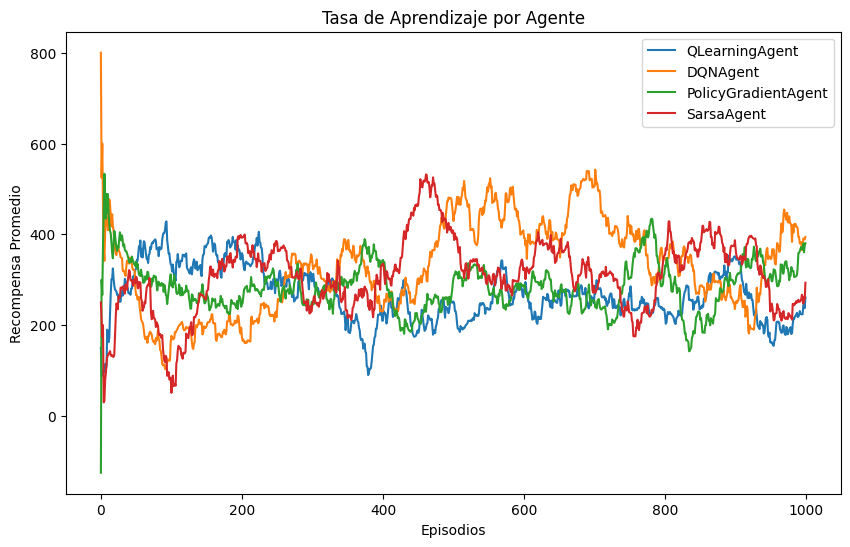

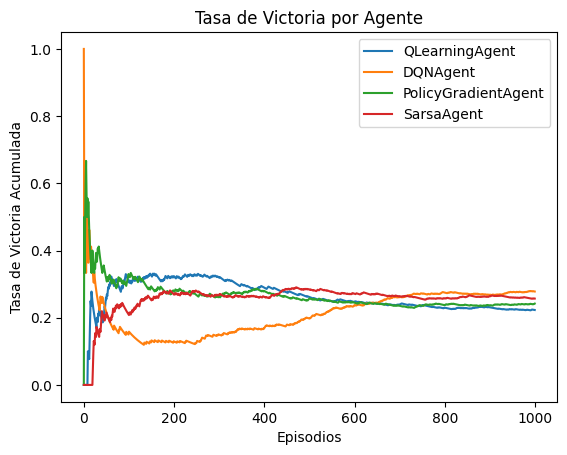

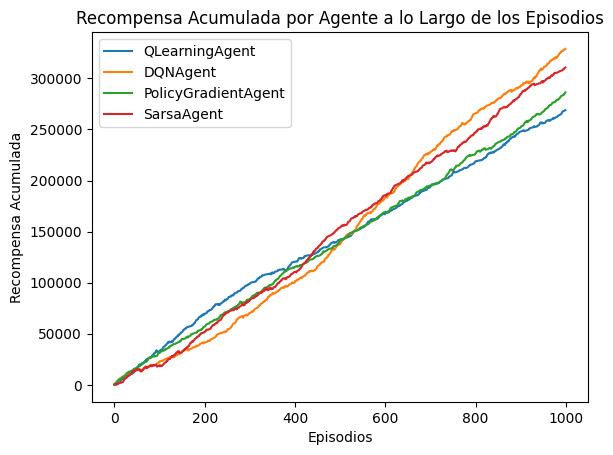

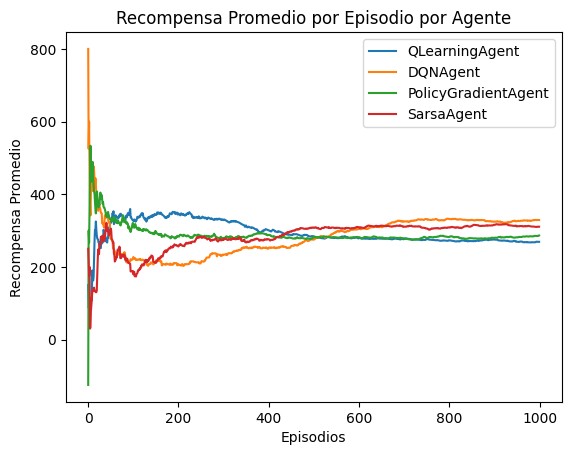

C:\Users\ivanh\AppData\Local\Temp\ipykernel_10180\3181147652.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=list(passes_per_agent.keys()), y=list(passes_per_agent.values()), palette='viridis')


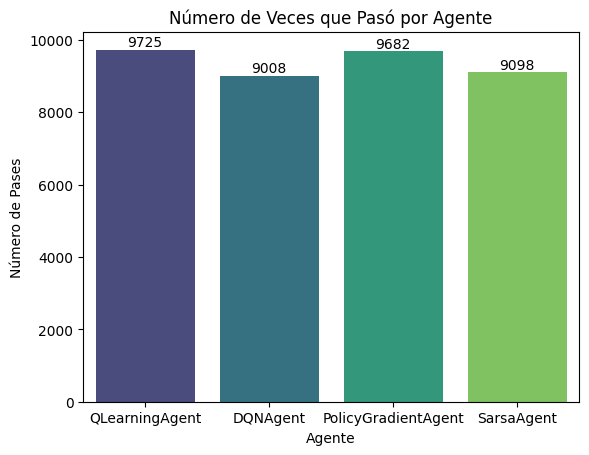

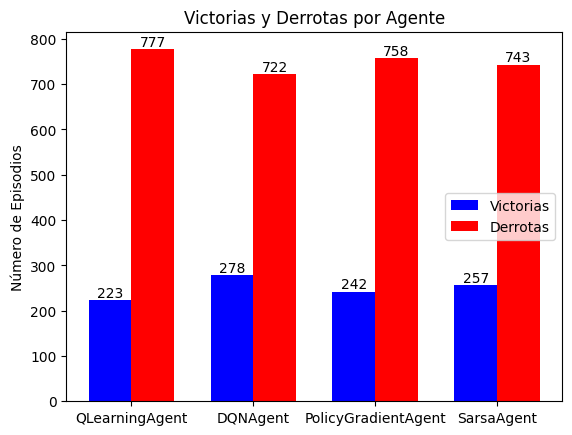

C:\Users\ivanh\AppData\Local\Temp\ipykernel_10180\3181147652.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=list(average_cards_left.keys()), y=list(average_cards_left.values()), palette='viridis')


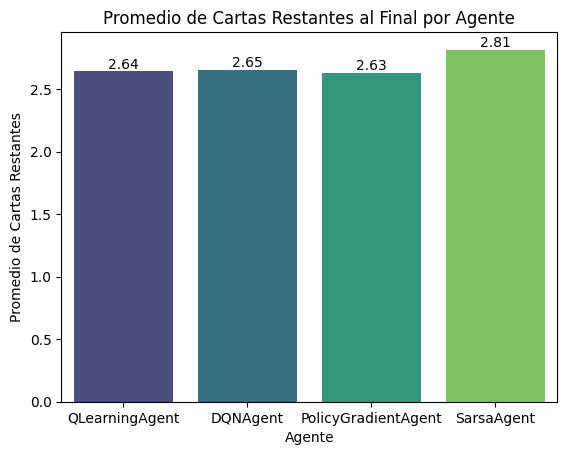

C:\Users\ivanh\AppData\Local\Temp\ipykernel_10180\3181147652.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=sizes, y=counts, palette='viridis')
C:\Users\ivanh\AppData\Local\Temp\ipykernel_10180\3181147652.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=sizes, y=counts, palette='viridis')
C:\Users\ivanh\AppData\Local\Temp\ipykernel_10180\3181147652.py:118: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=sizes, y=counts, palette='viridis')
C:\Users\ivanh\AppData\Local\Temp\ipykernel_10180\31811

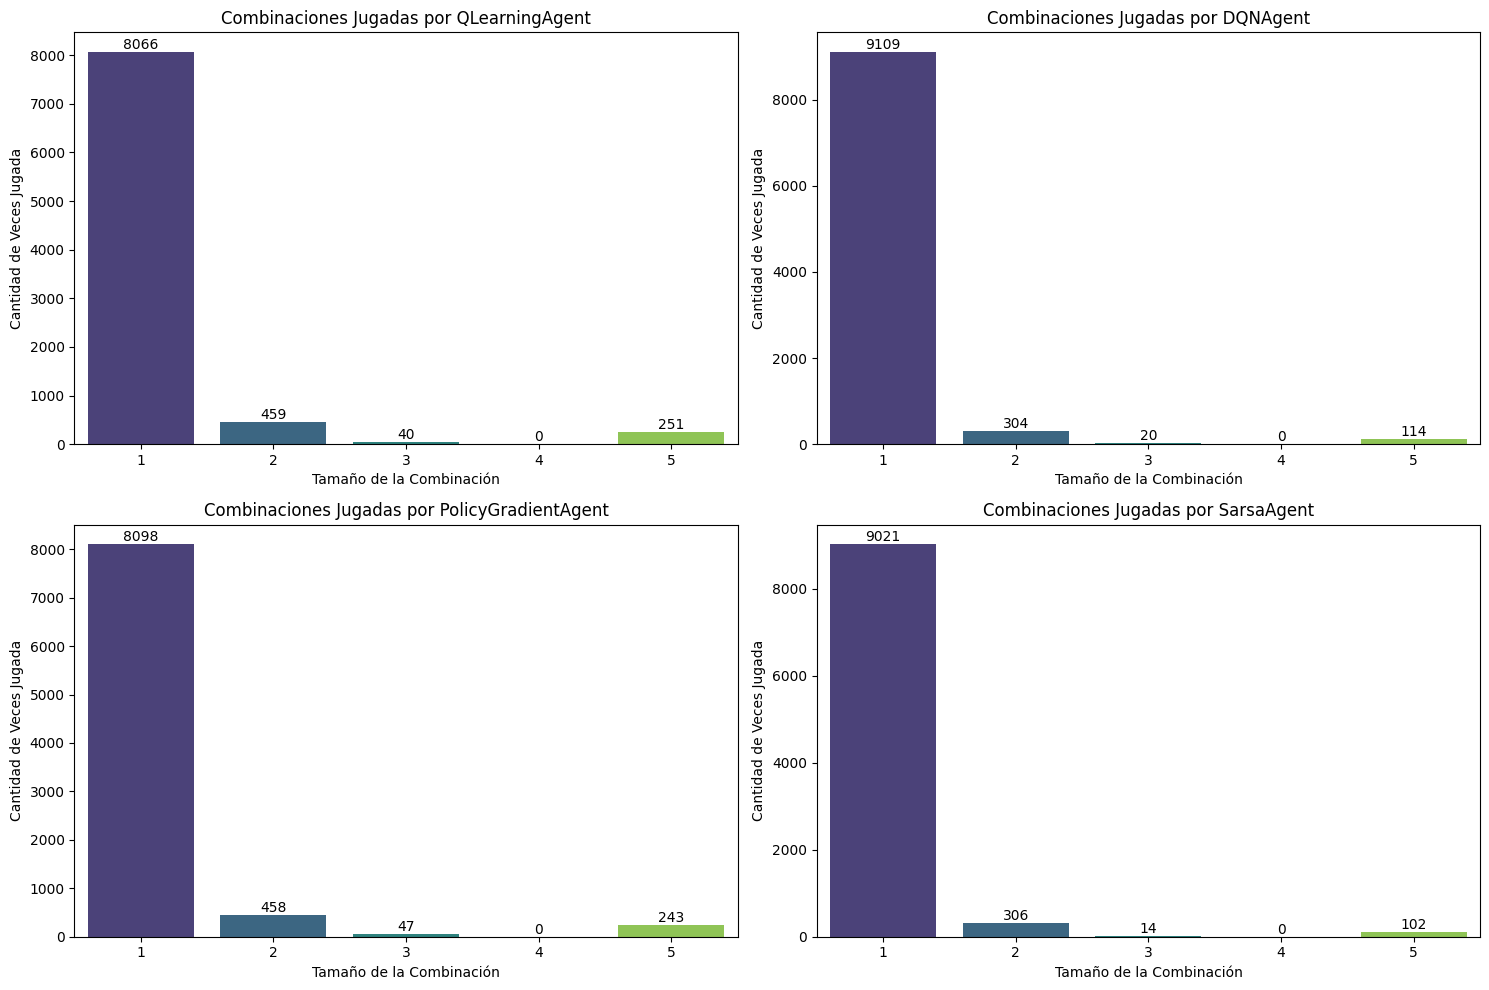

In [21]:
'''
Resultados
'''
# Gráfica de la Tasa de aprendizaje
plt.figure(figsize=(10, 6))
for agent_name, avg_rewards in average_reward_history.items():
    plt.plot(avg_rewards, label=agent_name)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Tasa de Aprendizaje por Agente')
plt.legend()
plt.show()

# Calcular la tasa de victoria por agente
victory_rates = {agent_name: [] for agent_name in agent_names}
for agent_name in agent_names:
    wins = [1 if winner == agent_name else 0 for winner in winners]
    victory_rates[agent_name] = np.cumsum(wins) / np.arange(1, len(wins) + 1)

# Graficar la tasa de victoria por agente
for agent_name, rates in victory_rates.items():
    plt.plot(rates, label=agent_name)
plt.xlabel('Episodios')
plt.ylabel('Tasa de Victoria Acumulada')
plt.title('Tasa de Victoria por Agente')
plt.legend()
plt.show()

# Calcular la recompensa acumulada por episodio para cada agente
cumulative_rewards = {agent_name: np.cumsum(rewards) for agent_name, rewards in reward_history.items()}

# Graficar la recompensa acumulada por episodio
for agent_name, rewards in cumulative_rewards.items():
    plt.plot(rewards, label=agent_name)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Acumulada')
plt.title('Recompensa Acumulada por Agente a lo Largo de los Episodios')
plt.legend()
plt.show()

# Calcular la recompensa promedio por episodio
average_rewards = {agent_name: [] for agent_name in agent_names}
for agent_name in agent_names:
    cumulative_sum = 0
    averages = []
    for i, reward in enumerate(reward_history[agent_name]):
        cumulative_sum += reward
        averages.append(cumulative_sum / (i + 1))
    average_rewards[agent_name] = averages

# Graficar la recompensa promedio por episodio
for agent_name, averages in average_rewards.items():
    plt.plot(averages, label=agent_name)
plt.xlabel('Episodios')
plt.ylabel('Recompensa Promedio')
plt.title('Recompensa Promedio por Episodio por Agente')
plt.legend()
plt.show()


# Gráfico de número de veces que pasó por agente
# plt.subplot(2, 2, 2)
bar_plot = sns.barplot(x=list(passes_per_agent.keys()), y=list(passes_per_agent.values()), palette='viridis')
# Agregar valores en cada barra
for index, value in enumerate(passes_per_agent.values()):
    bar_plot.text(index, value, str(value), ha='center', va='bottom')
plt.title('Número de Veces que Pasó por Agente')
plt.xlabel('Agente')
plt.ylabel('Número de Pases')
plt.show()

# Gráfico de victorias y derrotas
total_episodes = num_episodes
defeats_per_agent = {agent_name: total_episodes - wins for agent_name, wins in victory_counts.items()}

# plt.subplot(2, 2, 3)
x = np.arange(len(agent_names))
width = 0.35
bar_victories = plt.bar(x - width/2, list(victory_counts.values()), width, label='Victorias', color='b')
bar_defeats = plt.bar(x + width/2, [defeats_per_agent[agent_name] for agent_name in agent_names], width, label='Derrotas', color='r')
# Agregar valores en las barras
for bar in bar_victories:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')
for bar in bar_defeats:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')
plt.xticks(x, agent_names)
plt.ylabel('Número de Episodios')
plt.title('Victorias y Derrotas por Agente')
plt.legend()
plt.show()

# Gráfico de promedio de cartas restantes al final
average_cards_left = {agent_name: np.mean(cards_left_per_agent[agent_name]) for agent_name in agent_names}

# plt.subplot(2, 2, 4)
bar_plot = sns.barplot(x=list(average_cards_left.keys()), y=list(average_cards_left.values()), palette='viridis')
# Agregar valores en cada barra
for index, value in enumerate(average_cards_left.values()):
    bar_plot.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.title('Promedio de Cartas Restantes al Final por Agente')
plt.xlabel('Agente')
plt.ylabel('Promedio de Cartas Restantes')
plt.show()

# plt.tight_layout()
# plt.show()


# Gráfica de combinaciones jugadas por tamaño para cada agente
plt.figure(figsize=(15, 10))
n = 1
for agent_name in agent_names:
    plt.subplot(2, 2, n)
    n = n+1
    combination_counts = combination_counts_per_agent[agent_name]
    sizes = list(combination_counts.keys())
    counts = list(combination_counts.values())
    bar_plot = sns.barplot(x=sizes, y=counts, palette='viridis')
    for index, value in enumerate(counts):
        bar_plot.text(index, value, str(value), ha='center', va='bottom')
    plt.title(f'Combinaciones Jugadas por {agent_name}')
    plt.xlabel('Tamaño de la Combinación')
    plt.ylabel('Cantidad de Veces Jugada')
    
plt.tight_layout()    
plt.show()
